## fetching data from open meteo 

Oslo, Kristiansand, Trondheim, Tromsø and Bergen 
- temperature 2m
- precipitation
- wind speed 10 m 
- wind gusts 10 m 
- wind direction 10 m

Use the open-meteo API to retrieve historical reanalysis data using the ERA5 model for a single location as follows:

Create a function for the API download task that takes a pair of longitude and latitude values, plus a year as input and downloads the same weather properties as were used in the CSV file in part 1 of the project work.
Apply the function to download data for Bergen for the year 2019.



In [50]:
import pandas as pd 
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import openmeteo_requests
import requests_cache
from retry_requests import retry
import scipy

In [ ]:
#Saving price area codes, city names, longitude and latitude in a Pandas data frame.

data = [
    ['NO1', 'Oslo', 10.7522, 59.9139],
    ['NO2', 'Kristiansand', 8.0000, 58.1467],
    ['NO3', 'Trondheim', 10.3951, 63.4305],
    ['NO4', 'Tromsø', 18.9553, 69.6496],
    ['NO5', 'Bergen', 5.3221, 60.39299],
]

df = pd.DataFrame(data, columns=['PriceArea', 'City', 'Longitude', 'Latitude'])
print(df)

  PriceArea          City  Longitude  Latitude
0       NO1          Oslo    10.7522  59.91390
1       NO2  Kristiansand     8.0000  58.14670
2       NO3     Trondheim    10.3951  63.43050
3       NO4        Tromsø    18.9553  69.64960
4       NO5        Bergen     5.3221  60.39299


In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)



In [ ]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 60.393,
	"longitude": 5.3242,
	"start_date": "2019-01-01",
	"end_date": "2019-12-31",
	"hourly": ["temperature_2m", "precipitation", "wind_speed_10m", "wind_gusts_10m", "wind_direction_10m"],
}
responses = openmeteo.weather_api(url, params=params)


if len(responses) > 0:
    print('Success')
else: 
    print('No data fetched ')

In [ ]:
# Process Bergen weather data 
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print("\nHourly data\n", hourly_dataframe)

Coordinates: 60.421791076660156°N 5.2941179275512695°E
Elevation: 17.0 m asl
Timezone difference to GMT+0: 0s

Hourly data
                           date  temperature_2m  precipitation  wind_speed_10m  \
0    2019-01-01 00:00:00+00:00           5.772            0.2       41.036842   
1    2019-01-01 01:00:00+00:00           6.072            0.7       42.033756   
2    2019-01-01 02:00:00+00:00           6.322            0.5       40.913490   
3    2019-01-01 03:00:00+00:00           5.822            1.1       41.238468   
4    2019-01-01 04:00:00+00:00           5.722            0.7       44.140755   
...                        ...             ...            ...             ...   
8755 2019-12-31 19:00:00+00:00           4.972            0.7       11.525623   
8756 2019-12-31 20:00:00+00:00           5.872            0.7       12.984975   
8757 2019-12-31 21:00:00+00:00           6.372            0.3       14.618837   
8758 2019-12-31 22:00:00+00:00           6.122            0.1     

In [7]:
hourly_dataframe.describe()

,temperature_2m,precipitation,wind_speed_10m,wind_gusts_10m,wind_direction_10m
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,7.828758,0.246450,10.685799,29.520823,186.511353
std,5.999574,0.583147,6.047772,16.090151,96.201706
min,-12.878000,0.000000,0.000000,2.520000,1.169115
25%,3.072000,0.000000,6.120000,16.919998,116.564987
50%,7.222000,0.000000,9.531505,26.639999,164.836456
75%,12.084500,0.200000,14.332340,39.599998,279.462250
max,31.722000,9.500000,46.675217,131.040009,360.000000


In [8]:
hourly_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   date                8760 non-null   datetime64[ns, UTC]
 1   temperature_2m      8760 non-null   float32            
 2   precipitation       8760 non-null   float32            
 3   wind_speed_10m      8760 non-null   float32            
 4   wind_gusts_10m      8760 non-null   float32            
 5   wind_direction_10m  8760 non-null   float32            
dtypes: datetime64[ns, UTC](1), float32(5)
memory usage: 239.7 KB


In [37]:
# checking for summer time

print(f"SUMMER: {hourly_dataframe.iloc[int(len(hourly_dataframe)/2)].date}")
print("-"*33)
print(f"WINTER: {hourly_dataframe.iloc[0].date}")


SUMMER: 2019-07-02 12:00:00+00:00
---------------------------------
WINTER: 2019-01-01 00:00:00+00:00


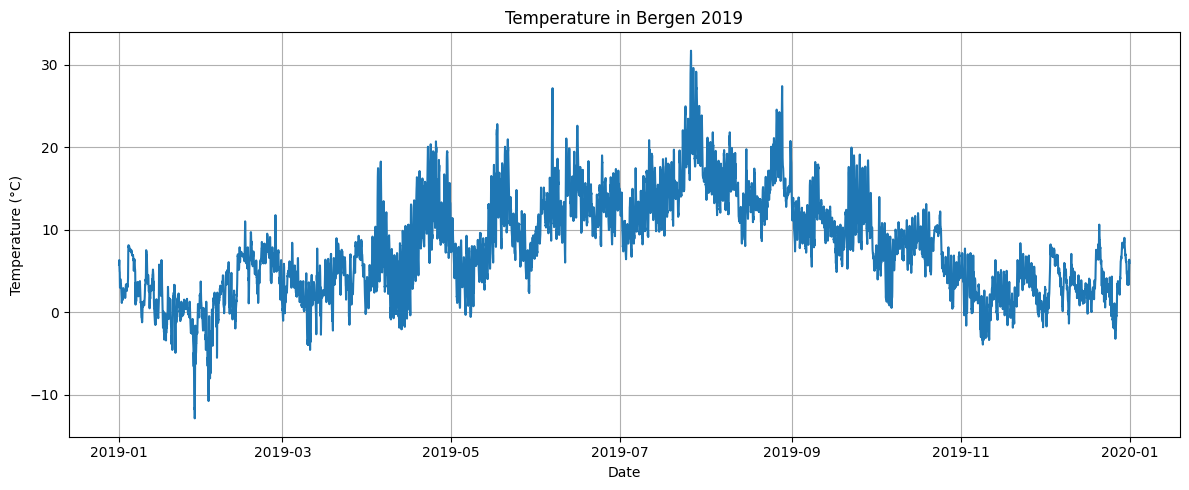

In [49]:
# Plotting temperature as a function of time 


plt.figure(figsize=(12, 5))
plt.plot(hourly_dataframe["date"], hourly_dataframe["temperature_2m"], label="Temperature (°C)")

plt.title("Temperature in Bergen 2019")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.tight_layout()
plt.grid(True)


Perform a high-pass filtering of the temperature using Direct Cosine Transfer to create seasonally adjusted temperature variations (SATV)

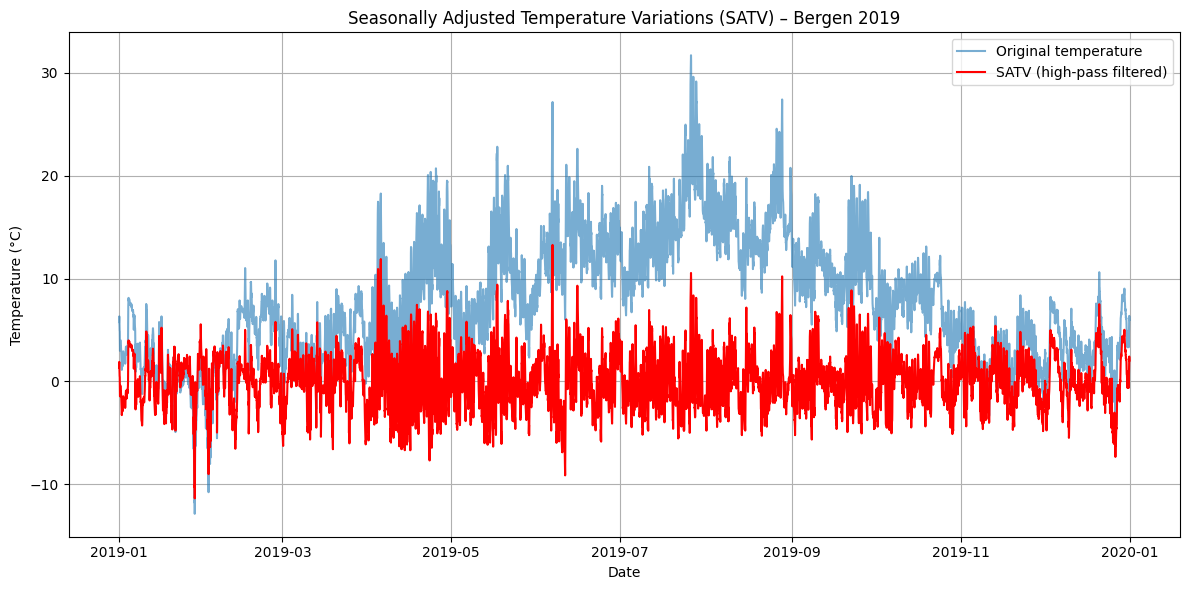

In [51]:
from scipy.fft import dct, idct

# Saving temperature data in numpy array 
temps = hourly_dataframe["temperature_2m"].to_numpy()

# Calculating DCT
temps_dct = dct(temps, norm='ortho')

# High pass filtering 
# Fjern de første lave frekvensene (de representerer sesong/middelverdi)
cutoff = 50   # juster denne terskelen – lavere verdi = fjerner mer sesong
temps_dct_hp = temps_dct.copy()
temps_dct_hp[:cutoff] = 0  # nullstill de første frekvensene

#  Invers DCT for å rekonstruere signalet ---
temps_satv = idct(temps_dct_hp, norm='ortho')

# --- 5. Plot resultatet ---
plt.figure(figsize=(12,6))
plt.plot(hourly_dataframe["date"], temps, label="Original temperature", alpha=0.6)
plt.plot(hourly_dataframe["date"], temps_satv, label="SATV (high-pass filtered)", color='red')
plt.title("Seasonally Adjusted Temperature Variations (SATV) – Bergen 2019")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

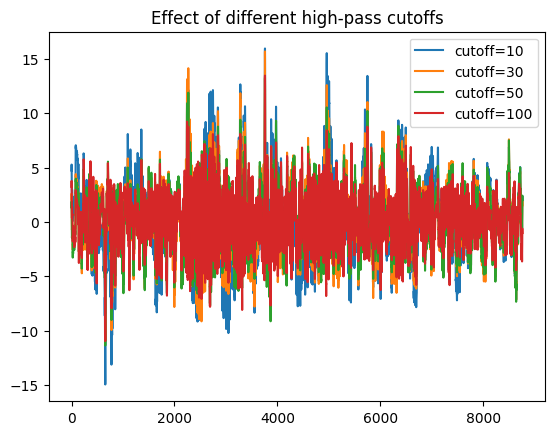

In [52]:
for c in [10, 30, 50, 100]:
    temps_dct_hp = temps_dct.copy()
    temps_dct_hp[:c] = 0
    temps_satv = idct(temps_dct_hp, norm='ortho')
    plt.plot(temps_satv, label=f'cutoff={c}')

plt.legend()
plt.title('Effect of different high-pass cutoffs')
plt.show()


In [53]:
# --- 1. Robust statistikk fra SATV ---
median_satv = np.median(temps_satv)
mad_satv = np.median(np.abs(temps_satv - median_satv))

# Sett kontrollgrenser (for eksempel ±3 * MAD)
upper_limit = median_satv + 3 * mad_satv
lower_limit = median_satv - 3 * mad_satv

print(f"MAD: {mad_satv:.2f}")
print(f"Upper limit: {upper_limit:.2f}, Lower limit: {lower_limit:.2f}")


MAD: 1.57
Upper limit: 4.67, Lower limit: -4.75


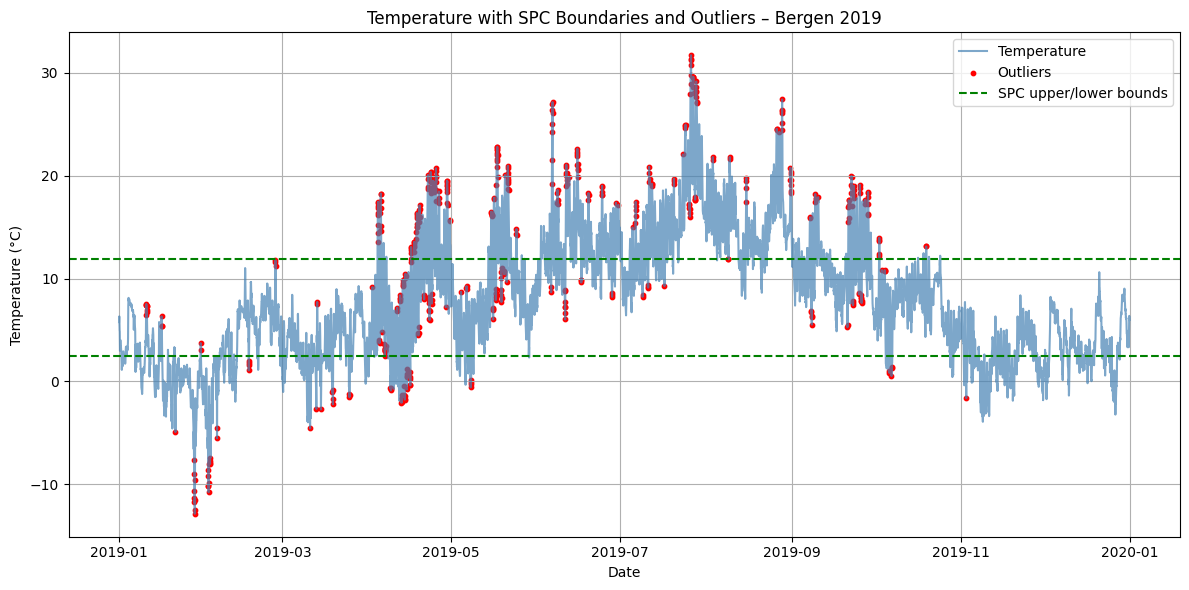

In [54]:
# Finn ut hvor SATV er utenfor grensene
outliers = (temps_satv > upper_limit) | (temps_satv < lower_limit)

# Hent datoer og temperaturer for utliggere
dates = hourly_dataframe["date"]
temps = hourly_dataframe["temperature_2m"]

# --- 4. Plot ---
plt.figure(figsize=(12,6))
plt.plot(dates, temps, label="Temperature", color="steelblue", alpha=0.7)
plt.scatter(dates[outliers], temps[outliers], color="red", label="Outliers", s=10)

# Legg inn SPC-grenser (de er relative, så vi må legge dem til middelverdien av temps)
baseline = np.median(temps)
plt.axhline(baseline + upper_limit, color="green", linestyle="--", label="SPC upper/lower bounds")
plt.axhline(baseline + lower_limit, color="green", linestyle="--")

plt.title("Temperature with SPC Boundaries and Outliers – Bergen 2019")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


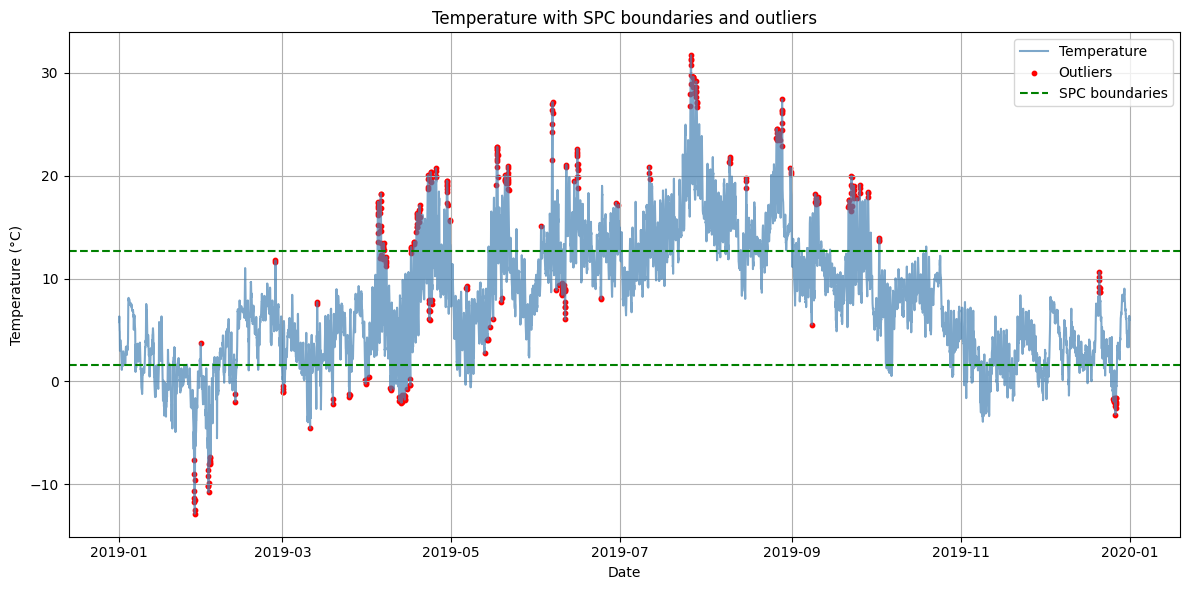


Summary:
Total points: 8760.00
Outlier count: 348.00
Outlier percentage: 3.97
MAD: 1.8582687377929688
Upper limit: 5.497061252593994
Lower limit: -5.652551174163818


In [ ]:
def plot_temperature_with_spc(df, temp_col="temperature_2m", date_col="date", 
                              cutoff=50, n_std=3):
    """
    Plot temperature over time, add SPC boundaries based on SATV (DCT high-pass filtered signal),
    and highlight outliers.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing date and temperature columns.
        temp_col (str): Name of the temperature column.
        date_col (str): Name of the datetime column.
        cutoff (int): Number of low DCT frequencies to remove (high-pass filter).
        n_std (float): Number of MAD deviations defining SPC boundaries.
    
    Returns:
        outlier_summary (pd.DataFrame): DataFrame with timestamps and temperatures of outliers.
    """

    # --- 1. Hent data ---
    temps = df[temp_col].to_numpy()
    dates = pd.to_datetime(df[date_col])

    # --- 2. DCT og high-pass filter ---
    temps_dct = dct(temps, norm='ortho')
    temps_dct_hp = temps_dct.copy()
    temps_dct_hp[:cutoff] = 0  # fjerner lavfrekvente komponenter
    temps_satv = idct(temps_dct_hp, norm='ortho')

    # --- 3. Robust statistikk ---
    median_satv = np.median(temps_satv)
    mad_satv = np.median(np.abs(temps_satv - median_satv))
    upper_limit = median_satv + n_std * mad_satv
    lower_limit = median_satv - n_std * mad_satv

    # --- 4. Finn utliggere ---
    outliers = (temps_satv > upper_limit) | (temps_satv < lower_limit)
    outlier_df = df.loc[outliers, [date_col, temp_col]].copy()
    outlier_df["SATV_value"] = temps_satv[outliers]

    # --- 5. Plot ---
    plt.figure(figsize=(12,6))
    plt.plot(dates, temps, label="Temperature", color="steelblue", alpha=0.7)
    plt.scatter(dates[outliers], temps[outliers], color="red", s=10, label="Outliers")

    baseline = np.median(temps)
    plt.axhline(baseline + upper_limit, color="green", linestyle="--", label="SPC boundaries")
    plt.axhline(baseline + lower_limit, color="green", linestyle="--")

    plt.title("Temperature with SPC boundaries and outliers")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 6. Oppsummering ---
    summary = {
        "Total points": len(df),
        "Outlier count": outlier_df.shape[0],
        "Outlier percentage": 100 * outlier_df.shape[0] / len(df),
        "MAD": mad_satv,
        "Upper limit": upper_limit,
        "Lower limit": lower_limit
    }

    print("\nSummary:")
    for k, v in summary.items():
        print(f"{k}: {v:.2f}" if isinstance(v, (int, float)) else f"{k}: {v}")

    return outlier_df

outliers = plot_temperature_with_spc(hourly_dataframe, cutoff=50, n_std=3)

